# Problem 1

In [44]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import math
import torch
from sklearn.model_selection import train_test_split

In [45]:
f = gzip.open('mnist.pkl.gz') 
mnist = pickle.load(f, encoding='latin1')

In [46]:
mnist_train_features = mnist[0][0] #(50000,784)
mnist_train_labels = mnist[0][1]   #(50000,1)

mnist_valid_features = mnist[1][0] #(10000,784)
mnist_valid_labels = mnist[1][1]   #(10000,1)

mnist_test_features = mnist[2][0]  #(10000,784)
mnist_test_labels = mnist[2][1]    #(10000,1)

In [47]:
# Reduce the dataset size for testing, if needed (ex: X_train = mnist_train_features[0:10000])
X_train = mnist_train_features[0:50000]
y_train = mnist_train_labels[0:50000]

X_valid = mnist_valid_features[0:10000]
y_valid = mnist_valid_labels[0:10000]

X_test = mnist_test_features[0:10000]
y_test = mnist_test_labels[0:10000]

## Building the Model

In [48]:
class NN(object):
    
    def __init__(self,hidden_dims=(1024,2048),weight_mode=None, mode="ReLU"):
        self.b1 = np.zeros((hidden_dims[0]))
        self.b2 = np.zeros((hidden_dims[1]))
        self.b3 = np.zeros((10))
        self.learning_rate = 0.0005
        self.initialize_weights(hidden_dims,weight_mode)
        self.act_mode = mode

    def initialize_weights(self,hidden_dims,weight_mode):
        W1_dim = (784, hidden_dims[0])
        W2_dim = (hidden_dims[0], hidden_dims[1])
        W3_dim = (hidden_dims[1], 10)
        
        if weight_mode == "zero":
            self.W1 = np.zeros(W1_dim)
            self.W2 = np.zeros(W2_dim)
            self.W3 = np.zeros(W3_dim)
            
        elif weight_mode == "normal":
            np.random.seed(23)
            self.W1 = np.random.standard_normal(W1_dim)
            self.W2 = np.random.standard_normal(W2_dim)
            self.W3 = np.random.standard_normal(W3_dim)
            
        elif weight_mode == "glorot":
            np.random.seed(23)
            
            d1 = math.sqrt(6.0 / (W1_dim[0] + W1_dim[1]))
            d2 = math.sqrt(6.0 / (W2_dim[0] + W2_dim[1]))
            d3 = math.sqrt(6.0 / (W3_dim[0] + W3_dim[1]))
            
            self.W1 = np.random.uniform(-d1, d1, W1_dim)
            self.W2 = np.random.uniform(-d2, d2, W2_dim)
            self.W3 = np.random.uniform(-d3, d3, W3_dim)
        
        else:
            raise Exception("Unsupported weight_mode value")

    def forward(self,data):
        cache = {}
        
        cache["h0"] = np.copy(data)
        cache["a1"] = np.dot(cache["h0"], self.W1) + self.b1
        cache["h1"] = self.activation(cache["a1"], self.act_mode)
        cache["a2"] = np.dot(cache["h1"], self.W2) + self.b2
        cache["h2"] = self.activation(cache["a2"], self.act_mode)
        cache["a3"] = np.dot(cache["h2"], self.W3) + self.b3
        cache["h3"] = self.softmax(cache["a3"])
        
        return cache

    def activation(self,data, mode="ReLU"):
        if(mode == "ReLU"):
            return self.ReLU(data)
        elif(mode == "sigmoid"):
            return self.sigmoid(data)
        else:
            raise Exception("Not an activation function")
    
    def activation_derivative(self,data, mode="ReLU"): # RELU derivative
        if(mode == "ReLU"):
            return self.ReLU_derivative(data)
        elif(mode == "sigmoid"):
            return self.sigmoid_derivative(data)
        else:
            raise Exception("Not an activation function")
    
    def sigmoid(self, data):
        return 1/(1+np.exp(-data))
    
    def sigmoid_derivative(self,data):
        return self.sigmoid(data)*(1-self.sigmoid(data))
    
    def ReLU(self,data): # RELU
        return np.where(data > 0, data, 0.0)
    
    def ReLU_derivative(self,data):
        return np.where(data > 0, 1.0, 0.0)

    def loss(self, data, labels, eps = 1e-15): # Cross Entropy loss
        cache = self.forward(data)
        preds = np.clip(cache["h3"], eps, 1 - eps)
        preds = preds / np.sum(preds, axis=1)[:, np.newaxis]
        one_hot_truth = np.eye(10)[labels]
        log_loss = -np.diag(np.matmul(one_hot_truth,np.log(preds).T))
        return  np.average(log_loss)

    def softmax(self,data): # Numerically stable softmax
        result = np.exp(data - np.max(data, axis=1, keepdims=True))
        result = result / np.sum(result, axis=1, keepdims=True)
        return result

    def backward(self,cache,labels):
        grads = {}

        grads["a3"] = cache["h3"] - np.eye(10)[labels]
        grads["W3"] = np.dot(cache["h2"].T, grads["a3"])
        grads["b3"] = np.sum(grads["a3"], axis=0)
        
        grads["h2"] = np.dot(grads["a3"], self.W3.T)
        grads["a2"] = grads["h2"] * self.activation_derivative(cache["a2"], self.act_mode)
        grads["W2"] = np.dot(cache["h1"].T, grads["a2"])
        grads["b2"] = np.sum(grads["a2"], axis=0)
        
        grads["h1"] = np.dot(grads["a2"], self.W2.T)
        grads["a1"] = grads["h1"] * self.activation_derivative(cache["a1"], self.act_mode)
        grads["W1"] = np.dot(cache["h0"].T, grads["a1"])
        grads["b1"] = np.sum(grads["a1"], axis=0)
        
        return grads

    def update(self,grads):
        self.b3 -= (self.learning_rate * grads["b3"])
        self.W3 -= (self.learning_rate * grads["W3"])
        self.b2 -= (self.learning_rate * grads["b2"])
        self.W2 -= (self.learning_rate * grads["W2"])
        self.b1 -= (self.learning_rate * grads["b1"])
        self.W1 -= (self.learning_rate * grads["W1"])

    def train(self, train_data, train_labels, valid_data, valid_labels, mini_batch_size = 0, epochs = 10, learning_rate = 0.0005, lr_decay = 1, lr_decay_intervals = 0):
        self.learning_rate = learning_rate
        train_info = {}
        train_info["train_loss"] = []
        train_info["train_accuracy"] = []
        train_info["valid_loss"] = []
        train_info["valid_accuracy"] = []
        decay_flag = True
        
        data_mini = []
        label_mini = []
        
        if (mini_batch_size==0):
            mini_batch_size = np.shape(train_data)[0]
            
        if (lr_decay==1):
            decay_flag = False
            
        if (lr_decay>1):
            raise ValueError("lr_decay has to be equal or under to 1")
            
        if (decay_flag==True):
            if lr_decay_intervals!=0:
                lr_decay_intervals = lr_decay_intervals
            else:
                lr_decay_intervals = [0.2,0.6]
        
        for epoch in range(epochs):
            for i in range(0, np.shape(train_data)[0], mini_batch_size):
                
                #Mini-batch training
                data_mini = train_data[i:i + mini_batch_size]
                labels_mini = train_labels[i:i + mini_batch_size]
                
                #forward and backward propagation
                cache = self.forward(data_mini)
                grads = self.backward(cache,labels_mini)
                self.update(grads)
                
            #Measuring loss and accuracy
            predictions = np.argmax(cache["h3"], axis=1)
            train_accuracy = np.mean(predictions == labels_mini)
            train_loss = self.loss(data_mini, labels_mini)
            
            valid_cache = self.forward(valid_data)
            valid_pred = np.argmax(valid_cache["h3"], axis=1)
            valid_accuracy = np.mean(valid_pred == valid_labels)
            valid_loss = self.loss(valid_data, valid_labels)
            
            if(decay_flag):
                if (epoch in np.dot(lr_decay_intervals,epochs)):
                    learning_rate = learning_rate * lr_decay

            
            train_info["train_loss"].append(train_loss)
            train_info["train_accuracy"].append(train_accuracy)   
            train_info["valid_loss"].append(valid_loss)
            train_info["valid_accuracy"].append(valid_accuracy)
            print(f"Training epoch ", epoch + 1, "\t", "Accuracy: {0:.4f}".format(train_accuracy), "\t", "Loss: {0:.4f}".format(train_loss))
            print(f"Validation ", "\t", "\t", "Accuracy: {0:.4f}".format(valid_accuracy), "\t", "Loss: {0:.4f}".format(valid_loss), '\n')
        
        return train_info

    def test(self, data, labels):
        cache = self.forward(data)
        predictions = cache["h3"].argmax(1).astype(int)
        accuracy = np.mean(predictions == labels)
        return accuracy


## Initialization

zero
Training epoch  1 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  2 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  3 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  4 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  5 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  6 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  7 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  8 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  9 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  10 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy

C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in multiply
C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater


Training epoch  1 	 Accuracy: 0.0900 	 Loss: 2.3028
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  2 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  3 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  4 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  5 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  6 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  7 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  8 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  9 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1064 	 Loss: 2.3018 

Training epoch  10 	 Accuracy: 0.0900 	 Loss: 2.3025
Validation  	 	 Accuracy: 0.1

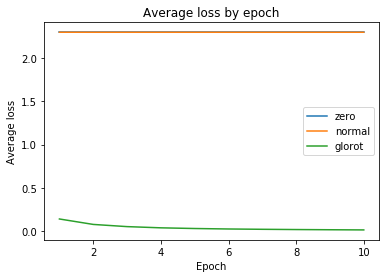

In [7]:
for weight_mode in ["zero", "normal", "glorot"]:
    print(weight_mode)
    nn = NN(hidden_dims=(800,300),weight_mode=weight_mode, mode="ReLU")
    train_info = nn.train(X_train, y_train, X_valid, y_valid, epochs = 10, mini_batch_size=100, learning_rate = 0.001, lr_decay = 0.5)
    plt.plot(np.arange(1,11,1), train_info["train_loss"], label=weight_mode)
    print()

plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

## Hyperparameter Search

In [ ]:
# Random Search, followed by Grid Search

# Fix this to change the way we see the results; h.p. ahve to be determined through curve analysis

lr = [0.012, 0.01, 0.008]
hiddens_dims = [(625,625)]
mini_batch = [32, 64, 128]
epoch = (20,18,22)


# Mode = ReLU
best = 0
best_params = {}

for lr_ in lr:
    for hd in hiddens_dims:
        for mb in mini_batch:
            for epoch_ in epoch:
                print("Lr : {}, epoch : {}".format(lr_, epoch_))
                model = NN(hidden_dims = hd, weight_mode = "glorot", mode = "ReLU")
                train_log = model.train(X_train, y_train, X_valid, y_valid, epochs = epoch_,
                                        mini_batch_size=mb, learning_rate = lr_, lr_decay = 0.8,
                                        lr_decay_intervals = [0.2, 0.5, 0.8])
                acc = model.test(X_valid, y_valid)
                if(acc>best):
                    best = acc
                    best_params["lr"] = lr_
                    best_params["hd"] = hd
                    best_params["mb"] = mb
                    best_params["epoch"]=epoch_
                              
print(best, best_params)

## Validating Gradients Using Finite Difference

In [52]:
lr = 0.008
hd = (800,300)
mb = 64
epoch = 10

model_finite_diff = NN(hidden_dims=hd, weight_mode="glorot", mode="ReLU")
log = model_finite_diff.train(X_train, y_train, X_valid, y_valid, epochs = epoch,
                                        mini_batch_size=mb, learning_rate = lr, lr_decay = 0.8,
                                        lr_decay_intervals = [0.2, 0.5, 0.8])



Training epoch  1 	 Accuracy: 0.9375 	 Loss: 0.0312
Validation  	 	 Accuracy: 0.9621 	 Loss: 0.1303 

Training epoch  2 	 Accuracy: 0.9375 	 Loss: 0.0067
Validation  	 	 Accuracy: 0.9666 	 Loss: 0.1080 

Training epoch  3 	 Accuracy: 1.0000 	 Loss: 0.0047
Validation  	 	 Accuracy: 0.9674 	 Loss: 0.1046 

Training epoch  4 	 Accuracy: 1.0000 	 Loss: 0.0028
Validation  	 	 Accuracy: 0.9746 	 Loss: 0.0900 

Training epoch  5 	 Accuracy: 1.0000 	 Loss: 0.0017
Validation  	 	 Accuracy: 0.9767 	 Loss: 0.0843 

Training epoch  6 	 Accuracy: 1.0000 	 Loss: 0.0013
Validation  	 	 Accuracy: 0.9780 	 Loss: 0.0862 

Training epoch  7 	 Accuracy: 1.0000 	 Loss: 0.0008
Validation  	 	 Accuracy: 0.9800 	 Loss: 0.0800 

Training epoch  8 	 Accuracy: 1.0000 	 Loss: 0.0013
Validation  	 	 Accuracy: 0.9786 	 Loss: 0.0862 

Training epoch  9 	 Accuracy: 1.0000 	 Loss: 0.0010
Validation  	 	 Accuracy: 0.9817 	 Loss: 0.0822 

Training epoch  10 	 Accuracy: 1.0000 	 Loss: 0.0015
Validation  	 	 Accuracy: 0.9

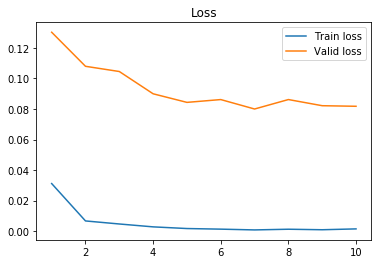

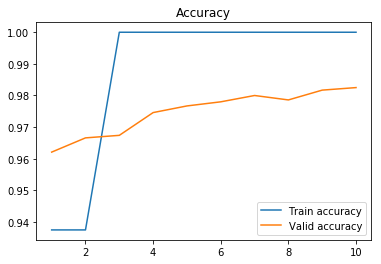

In [53]:
plt.figure()
plt.title("Loss")
plt.plot(np.arange(1,11,1), log["train_loss"], label = "Train loss")
plt.plot(np.arange(1,11,1), log["valid_loss"], label = "Valid loss")
plt.legend()

plt.figure()
plt.title("Accuracy")
plt.plot(np.arange(1,11,1), log["train_accuracy"], label = "Train accuracy")
plt.plot(np.arange(1,11,1), log["valid_accuracy"], label = "Valid accuracy")
plt.legend()

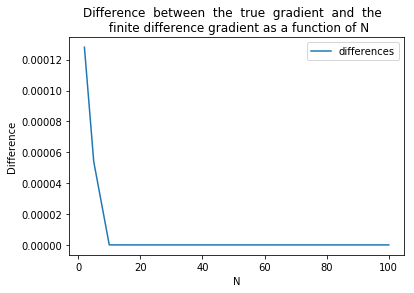

In [56]:
def finite_diff_gradient_check(model, sample_X, sample_Y, weights_idx = 10, n_values = None):
    """
    -----
    Parameters: 
        model: neural net with initialized weights
        sample_X : data point
        sample_Y : data point label
        weights_idx: first weights to evaluate theta = 1:weights_idx
        n_values: N values to try for finite difference, with epsilon = 1 / N
    """

    max_differences = []

    for n in n_values:
        max_difference = 0
        for i in range(weights_idx):
            eps = 1.0 / n

            cache = model_finite_diff.forward(sample_X)
            grads = model_finite_diff.backward(cache, sample_Y)
            grad = grads["W2"][0,i]

            model_finite_diff.W2[0,i] += eps
            loss_eps_plus = model_finite_diff.loss(sample_X, sample_Y)
            model_finite_diff.W2[0,i] -= 2*eps
            loss_eps_minus = model_finite_diff.loss(sample_X, sample_Y)
            model_finite_diff.W2[0,i] += eps
            finite_diff = (loss_eps_plus - loss_eps_minus)/(2*eps)


            difference = np.abs(grad - finite_diff)
            if difference > max_difference:
                max_difference = difference

        max_differences.append(max_difference)


    plt.plot(n_values, max_differences, label="differences")

    plt.title("Difference  between  the  true  gradient  and  the  \n finite difference gradient as a function of N")
    plt.xlabel("N")
    plt.ylabel("Difference")
    plt.legend()
    plt.show()
    
finite_diff_gradient_check(
    model_finite_diff, 
    (X_train[0, np.newaxis]), 
    y_train[0], 
    n_values=[2, 5, 10, 20, 100]
)